In [80]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.1.0
Eager mode:  True
GPU is available


In [2]:
# Разобьем обучающую выборку в пропорции 60% на 40%, и у нас будет 15,000 примеров
# для обучения, 10,000 примеров для валидации и 25,000 примеров для проверки.
# train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, test_data) = tfds.load(
    name="imdb_reviews", 
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True)

In [3]:
# Пример текста
test_label_example = next(iter(train_data.batch(2)))
test_label_example

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b"This was soul-provoking! I am an Iranian, and living in th 21st century, I didn't know that such big tribes have been living in such conditions at the time of my grandfather!<br /><br />You see that today, or even in 1925, on one side of the world a lady or a baby could have everything served for him or her clean and on-demand, but here 80 years ago, people ventured their life to go to somewhere with more grass. It's really interesting that these Persians bear those difficulties to find pasture for their sheep, but they lose many the sheep on their way.<br /><br />I praise the Americans who accompanied this tribe, they were as tough as Bakhtiari people.",
        b'Sitting down to watch the 14th season of the Bachelor ("On the Wings of Love"), I knew I would be in for an "interesting" time. I had watched some of the previous seasons of the Bachelor in passing; watching an episode or two and missing the next three or so. I find tha

In [37]:
def tokenize(tf_data):
    # Разбивка предложений на токены
    tokenizer = tfds.features.text.Tokenizer()
    # Создание и заполнение словаря токенами
    vocabulary_set = set()
    for data_sample in tf_data:
        for text_tensor, _ in data_sample:
            some_tokens = tokenizer.tokenize(text_tensor.numpy())
            vocabulary_set.update(some_tokens)
    vocab_size = len(vocabulary_set)
    print(f'Created vocab with {vocab_size} entries')
    return vocabulary_set, vocab_size


def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label

def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
    encoded_text, label = tf.py_function(encode,
                                         inp=[text, label], 
                                         Tout=(tf.int64, tf.int64))

  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
    encoded_text.set_shape([None])
    label.set_shape([])

    return encoded_text, label

In [38]:
vocabulary, vocab_size = tokenize((train_data, test_data))

Created vocab with 130065 entries


In [39]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary)

In [40]:
# Кодирование данных
encoded_train_data = train_data.map(encode_map_fn)
encoded_test_data = test_data.map(encode_map_fn)

In [70]:
encoded_train_data.padded_batch()

<MapDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [41]:
# sample_text, sample_labels = next(iter(encoded_train_data))

In [42]:
vocab_size += 1

In [72]:
BUFFER_SIZE = 1000

train_batches = (
    encoded_train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, padded_shapes=([None],[])))

test_batches = (
    encoded_test_data
    .padded_batch(32, padded_shapes=([None],[])))

In [74]:
for example_batch, label_batch in train_batches.take(2):
    print("Batch shape:", example_batch.shape)
    print("label shape:", label_batch.shape)

Batch shape: (32, 830)
label shape: (32,)
Batch shape: (32, 866)
label shape: (32,)


Embedding layer. Принимает закодированный encoder-ом словарь из цифр и создает признаковый вектор для каждого слова. По мере обучения модели, количество таких векторов увеличивается, добавляясь в выход слоя.

GlobalAveragePooling1D layer - создает векторы фиксированной длины за счет усреднения размеров последовательности. Слой имеет 16 скрытых нейронов.

На выходе полносвязный слой с 1 нейроном

In [83]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          2081072   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 2,081,089
Trainable params: 2,081,089
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/10
782/782 [==============================] - 46s 59ms/step - loss: 0.6767 - accuracy: 0.5022 - val_loss: 0.6475 - val_accuracy: 0.5125
Epoch 2/10
782/782 [==============================] - 44s 56ms/step - loss: 0.5904 - accuracy: 0.5907 - val_loss: 0.5543 - val_accuracy: 0.6187
Epoch 3/10
782/782 [==============================] - 45s 58ms/step - loss: 0.4909 - accuracy: 0.7291 - val_loss: 0.4767 - val_accuracy: 0.7823
Epoch 4/10
782/782 [==============================] - 45s 57ms/step - loss: 0.4150 - accuracy: 0.8103 - val_loss: 0.4195 - val_accuracy: 0.8031
Epoch 5/10
782/782 [==============================] - 46s 58ms/step - loss: 0.3615 - accuracy: 0.8490 - val_loss: 0.3784 - val_accuracy: 0.8208
Epoch 6/10
782/782 [==============================] - 46s 59ms/step - loss: 0.3188 - accuracy: 0.8744 - val_loss: 0.3469 - val_accuracy: 0.8542
Epoch 7/10
782/782 [==============================] - 45s 58ms/step - loss: 0.2847 - accuracy: 0.8898 - val_loss: 0.3232 - val_accuracy:

In [90]:
def get_accuracy_plots(history):
    
    """Plots accuracy-loss training profile"""
    
    history_dict = history.history
    # history_dict.keys()
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf()   # clear figure

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()


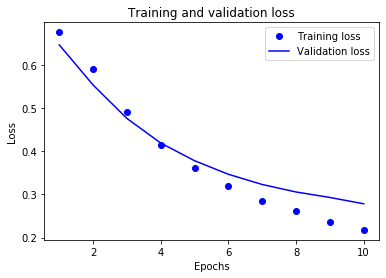

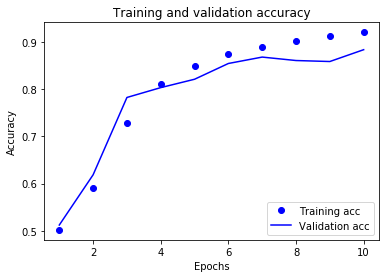

In [91]:
get_accuracy_plots(history)

Увеличим количество параметров в ~2.5 раз за счет добавления скрытых нейронов. В модели стали более заметны признаки переобучения.

In [107]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 40),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 40)          5202680   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 40)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 41        
Total params: 5,202,721
Trainable params: 5,202,721
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/10
782/782 [==============================] - 82s 105ms/step - loss: 0.6593 - accuracy: 0.5176 - val_loss: 0.6031 - val_accuracy: 0.5479
Epoch 2/10
782/782 [==============================] - 82s 105ms/step - loss: 0.5186 - accuracy: 0.6913 - val_loss: 0.4743 - val_accuracy: 0.7635
Epoch 3/10
782/782 [==============================] - 82s 105ms/step - loss: 0.4015 - accuracy: 0.8186 - val_loss: 0.3935 - val_accuracy: 0.8083
Epoch 4/10
782/782 [==============================] - 83s 106ms/step - loss: 0.3288 - accuracy: 0.8678 - val_loss: 0.3452 - val_accuracy: 0.8313
Epoch 5/10
782/782 [==============================] - 83s 106ms/step - loss: 0.2794 - accuracy: 0.8928 - val_loss: 0.3129 - val_accuracy: 0.8573
Epoch 6/10
782/782 [==============================] - 79s 101ms/step - loss: 0.2445 - accuracy: 0.9093 - val_loss: 0.2882 - val_accuracy: 0.8823
Epoch 7/10
782/782 [==============================] - 79s 101ms/step - loss: 0.2186 - accuracy: 0.9207 - val_loss: 0.2803 - val_ac

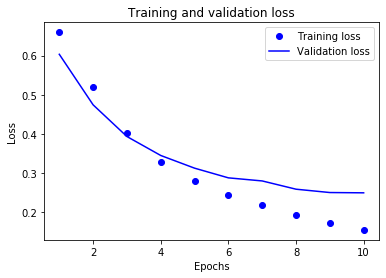

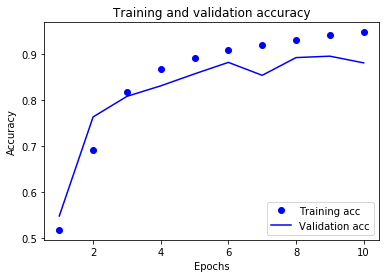

In [109]:
get_accuracy_plots(history)